<a href="https://colab.research.google.com/github/emely3h/Geospatial_ML/blob/main/experiment_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net Experiement 1: Exploring variance/ randomness

When running the exact same model with the exact same dataset we get slightly different results each time due to randomness and variability involved in the training process.
the variance refers to 
The goal of this notebook is to evaluate the variability in the results obtained from different training runs on the same dataset We will use the exact same setup and dataset as in the unet notebook and execute 10 training runs.

Difference to experiment_1: smaller learning rate, 0.0001 instead of 0.001

### 0. Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')
! ls

Mounted at /content/drive
drive  sample_data


In [2]:
%cd drive/MyDrive/MachineLearning/
!git clone https://github.com/emely3h/Geospatial_ML.git
%cd Geospatial_ML
#! git pull
#! git checkout feature/rerun-experiment-1-2
! ls

/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning
Cloning into 'Geospatial_ML'...
remote: Enumerating objects: 837, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 837 (delta 59), reused 48 (delta 46), pack-reused 694
Receiving objects: 100% (837/837), 32.67 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (478/478), done.
/content/drive/.shortcut-targets-by-id/15HUD3sGdfvxy5Y_bjvuXgrzwxt7TzRfm/MachineLearning/Geospatial_ML
architecture.drawio  evaluation   models	README.md
data_exploration     experiments  prepare_data	requirements.txt


In [3]:
from models.helpers import normalizing_encoding, define_model, train_model, save_model_history, make_predictions, save_metrics
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from models.unet_model import unet_2d
from models.helpers import get_mean_jaccard
from datetime import datetime
from prepare_data.create_mask import create_physical_mask
from evaluation.evaluation_metrics import EvaluationMetrics
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import tensorflow as tf
import matplotlib as plt
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

### 1. Loading + Preparing Data

In [4]:
root = "../data_colab/256_200/"

y_train  = np.load(os.path.join(root,'2022_06_20.npz'))['y_mask']
x_train  = np.load(os.path.join(root,'2022_06_20.npz'))['x_input']

y_val = np.load(os.path.join(root,'2022_07_10.npz'))['y_mask']
x_val = np.load(os.path.join(root,'2022_07_10.npz'))['x_input']

y_test = np.load(os.path.join(root, '2022_07_25.npz'))['y_mask']
x_test = np.load(os.path.join(root, '2022_07_25.npz'))['x_input']

print(y_train.shape)
print(x_train.shape)

print(y_val.shape)
print(x_val.shape)

print(y_test.shape)
print(x_test.shape)

(1251, 256, 256)
(1251, 256, 256, 5)
(1323, 256, 256)
(1323, 256, 256, 5)
(1258, 256, 256)
(1258, 256, 256, 5)


In [5]:
# Get physical prediction
train_physical = create_physical_mask(x_train)
val_physical = create_physical_mask(x_val)
test_physical = create_physical_mask(x_test)

print(train_physical.shape)
print(val_physical.shape)
print(test_physical.shape)

(1251, 256, 256, 3)
(1323, 256, 256, 3)
(1258, 256, 256, 3)


### 3. Normalizing + Encoding

In [6]:
x_train, y_train = normalizing_encoding(x_train, y_train)
X_val, y_val = normalizing_encoding(x_val, y_val)
x_test, y_test = normalizing_encoding(x_test, y_test)

y shape:  (1251, 256, 256)
Encoding data...
y one hot shape:  (1251, 256, 256, 3)
x shape:  (1251, 256, 256, 5)
y shape:  (1323, 256, 256)
Encoding data...
y one hot shape:  (1323, 256, 256, 3)
x shape:  (1323, 256, 256, 5)
y shape:  (1258, 256, 256)
Encoding data...
y one hot shape:  (1258, 256, 256, 3)
x shape:  (1258, 256, 256, 5)


### 4. Model summary

In [7]:
model = unet_2d(input_shape=(256, 256, 5), num_classes=3)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  2944        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

### 5. Execute trainings + saving results

In [8]:
tile_size = 256
step_size = 200
experiment = 'experiment_1'
all_metrics_test = []
all_metrics_val = []
all_metrics_train = []

In [9]:
!nvidia-smi

Wed Apr  5 01:24:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    52W / 400W |    753MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
def execute_multiple_trainings(num_of_executions, epochs):
  print(f'Start: {datetime.now()}')
  for count in range(0, num_of_executions):
      count += 10 # todo remove
      
      model = unet_2d(input_shape=(256, 256, 5), num_classes=3)
      model.compile(optimizer='adam', loss=categorical_crossentropy, metrics=['accuracy']) #Adam(learning_rate=0.0001)


      model.summary()
      print(f'Start training number {count}')
      
      # Train model
      early_stop = EarlyStopping(monitor='accuracy', patience=5)
      history = model.fit(x=x_train, y=y_train, epochs=epochs, validation_data=(x_val, y_val), callbacks=[early_stop])

      history = train_model(model, x_train, y_train, x_val, y_val, epochs=epochs)
      print('training completed')
      
      # Save model
      model_name = f'{tile_size}_{step_size}_run_{count}'
      model.save(f'../models/{experiment}/model_{model_name}.h5')
      print('saving model completed')
      
      # Save model history
      save_model_history(history, model_name, f'../models/{experiment}', count)
      print('saving history completed')
      
      # Predict 
      pred_train, pred_val, pred_test = make_predictions(model, x_train, x_val, x_test)
      print('prediction completed')



      metrics_train = EvaluationMetrics(y_train, pred_train, train_physical)
      metrics_val = EvaluationMetrics(y_val, pred_val, val_physical)
      metrics_test = EvaluationMetrics(y_test, pred_test, test_physical)
      
      print('metrics calculated')
      
      # Save metrics
      save_metrics(metrics_train, metrics_val, metrics_test, f'../metrics/{experiment}', count)

      print('saving metrics completed')
  
      print(f'Run {count} completed: {datetime.now()}')
  print(f'End: {datetime.now()}')
#del model
execute_multiple_trainings(10, 100)

# executed with premium gpu and high ram => 13,08 computing units per hour, took

Start: 2023-04-05 01:26:21.054530
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 5  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 256, 256, 64  2944        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_31 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_30[0][0]']              
                                )                         

KeyboardInterrupt: ignored

### 6. Histories + Metrics 

In [ ]:
history_path = '../models/experiment_1/'

def get_histories_of_experiment(history_path):
  histories = []
  for file in os.listdir(history_path):
    if file.startswith('history'):
      print(f'Adding: {file}')
      with open(os.path.join(history_path, file), 'rb') as f:
        data = pickle.load(f)
        histories.append(data)
  return histories


histories = get_histories_of_experiment(history_path)
print(f'Total amount of model histories: {len(histories)}')

Adding: history_256_200_run_0.pkl
Adding: history_256_200_run_1.pkl
Adding: history_256_200_run_2.pkl
Adding: history_256_200_run_3.pkl
Adding: history_256_200_run_4.pkl
Adding: history_256_200_run_5.pkl
Adding: history_256_200_run_6.pkl
Adding: history_256_200_run_7.pkl
Adding: history_256_200_run_8.pkl
Adding: history_256_200_run_9.pkl
Total amount of model histories: 10


In [ ]:
metric_path = '../metrics/experiment_1/'


def get_metrics_of_experiment(metric_path):
  training_metrics = []
  validation_metrics = []
  test_metrics = []

  for file in os.listdir(metric_path):
    if file.startswith('metrics'):
      print(file)

      with open(os.path.join(metric_path, file), 'rb') as f:
        data = pickle.load(f)
        data_set = file.split('_')[1]

        if data_set.startswith('train'):
          training_metrics.append(data)
        elif data_set.startswith('val'):
          validation_metrics.append(data)
        elif data_set.startswith('test'):
          test_metrics.append(data)
  return training_metrics, validation_metrics, test_metrics

training_metrics, validation_metrics, test_metrics = get_metrics_of_experiment(metric_path)

print(len(training_metrics))
print(len(validation_metrics))
print(len(test_metrics))


metrics_test_0.pkl
metrics_train_0.pkl
metrics_val_0.pkl
metrics_val_1.pkl
metrics_train_1.pkl
metrics_test_1.pkl
metrics_test_2.pkl
metrics_val_2.pkl
metrics_train_2.pkl
metrics_test_3.pkl
metrics_val_3.pkl
metrics_train_3.pkl
metrics_test_4.pkl
metrics_val_4.pkl
metrics_train_4.pkl
metrics_test_5.pkl
metrics_val_5.pkl
metrics_train_5.pkl
metrics_test_6.pkl
metrics_val_6.pkl
metrics_train_6.pkl
metrics_test_7.pkl
metrics_val_7.pkl
metrics_train_7.pkl
metrics_test_8.pkl
metrics_val_8.pkl
metrics_train_8.pkl
metrics_test_9.pkl
metrics_val_9.pkl
metrics_train_9.pkl
10
10
10


In [ ]:
def plot_loss_acc(plots, y_scale, model_history, scale):
  loss = model_history['loss']
  val_loss = model_history['val_loss']
  acc = model_history['accuracy']
  val_acc = model_history['val_accuracy']

  plt.figure(figsize=(10,6))
  if 'loss' in plots:
    plt.plot(loss, 'g', label='Training Loss')
  
  if 'accuracy' in plots:
    plt.plot(acc, 'y', label='Training Accuracy')
  
  if 'val_loss' in plots:
    plt.plot(val_loss, 'r', label='Validation Loss')
  
  if 'val_accuracy' in plots:
    plt.plot(val_acc, 'b', label='Validation Accuracy')

  plt.xlabel('Epoch')
  plt.ylabel('Value')
  plt.ylim(scale)

  plt.legend()

  plt.show()


In [ ]:
def print_all_metrics(metric, data_set):
  print(f'========= {data_set} ==========')  
  metric.print_metrics()
  print()
  print()

In [ ]:
def print_history_metrics_for_run(history, training_metrics, validation_metrics, test_metrics, scale_all, scale_loss, scale_acc):
  plot_loss_acc(['loss', 'accuracy', 'val_loss', 'val_accuracy'], 'all', history, scale_all)

  plot_loss_acc(['loss', 'val_loss',], 'loss', history, scale_loss)
  print()
  plot_loss_acc(['accuracy', 'val_accuracy'], 'accuracy', history, scale_acc)
  print()

  print_all_metrics(training_metrics, 'TRAINING SET')
  print()
  print()
  print_all_metrics(validation_metrics, 'VALIDATION SET')
  print()
  print()
  print_all_metrics(test_metrics, 'TEST SET')

#### Run 1

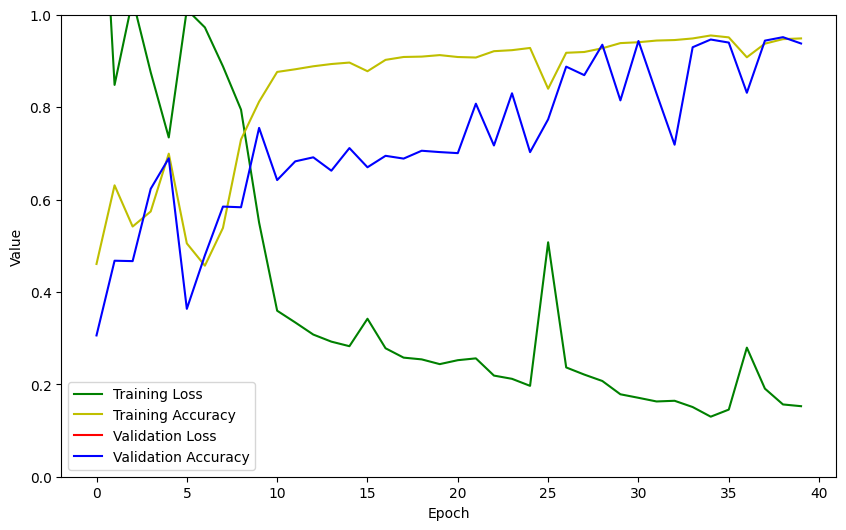

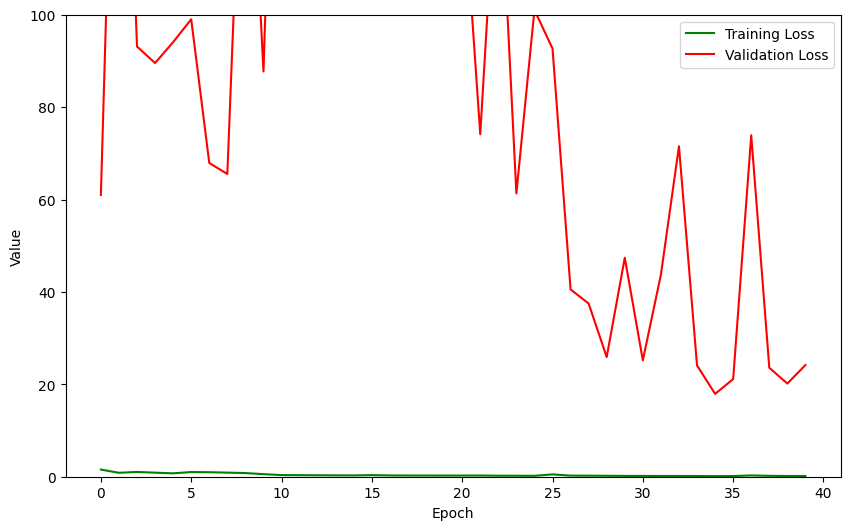

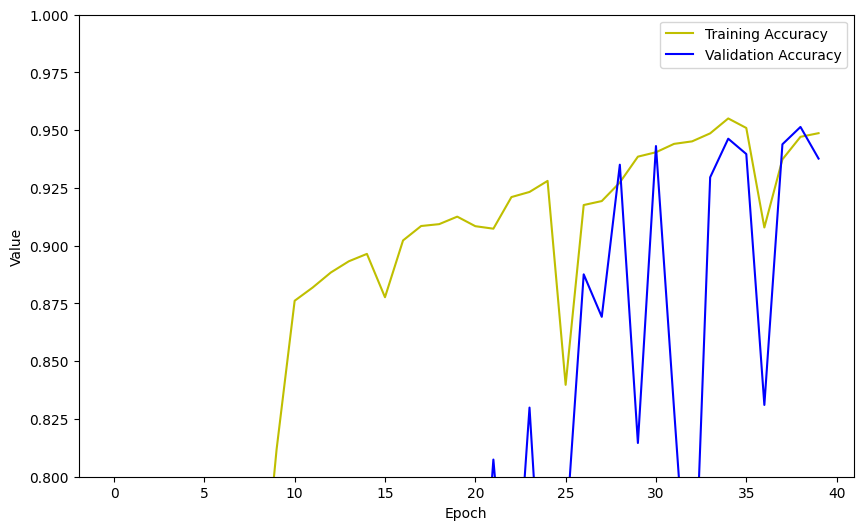


========= TRAINING SET ==========
jaccard index: 0.7908444404602051 

physical jaccard: 0.9383465051651001 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= VALIDATION SET ==========
jaccard index: 0.8827446699142456 

physical jaccard: 0.9339901208877563 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= TEST SET ==========
jaccard index: 0.8361419439315796 

physical jaccard: 0.9283590912818909 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
speci

In [ ]:
run = 0
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 100], [0.8, 1])

#### Run 2

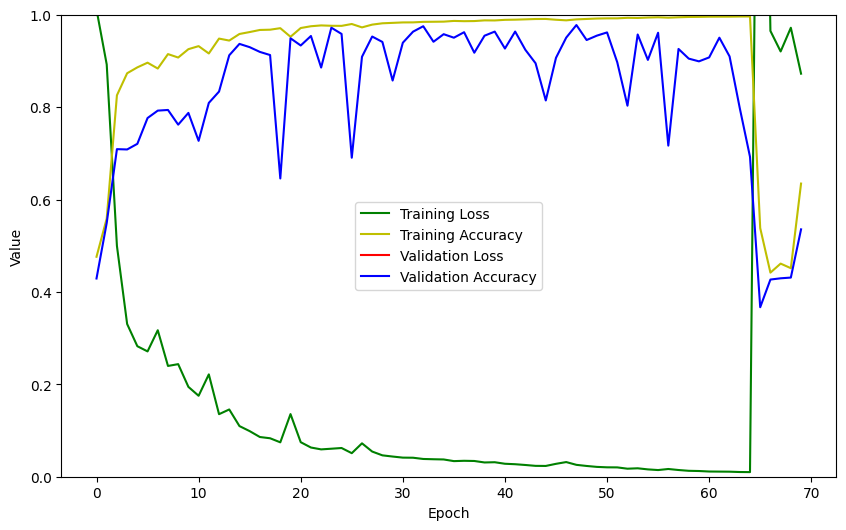

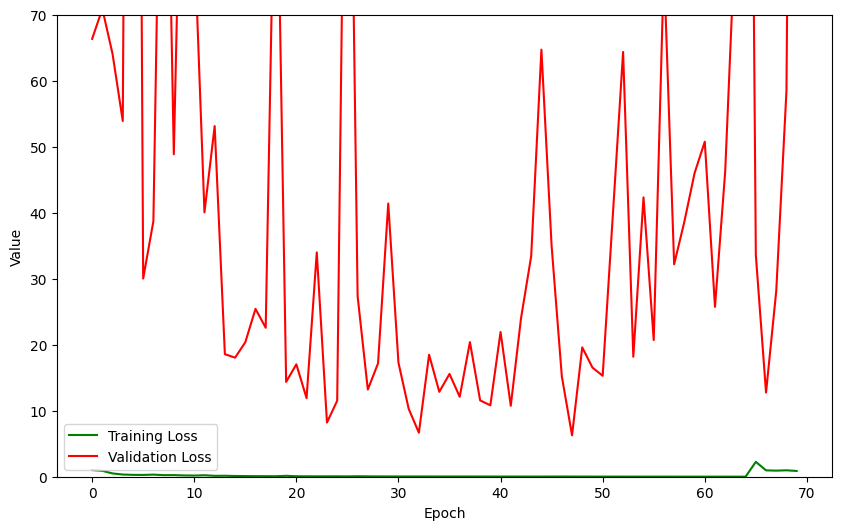

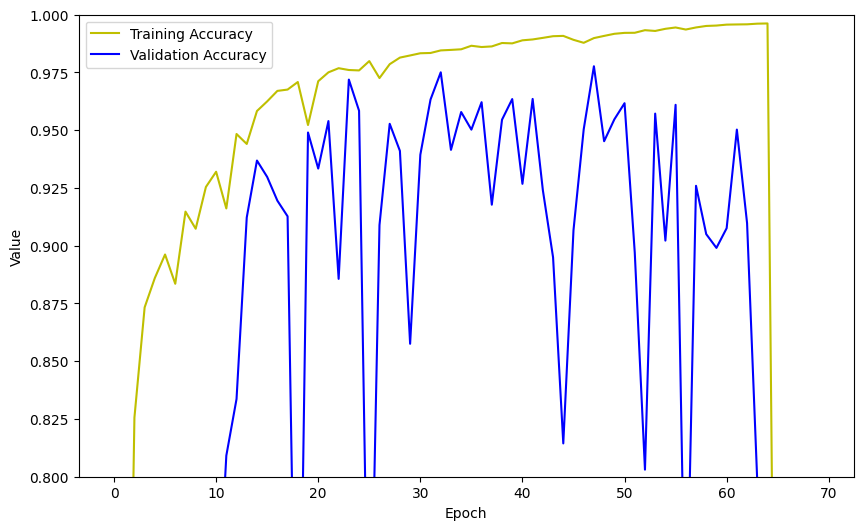


========= TRAINING SET ==========
jaccard index: 0.5310532450675964 

physical jaccard: 0.9383465051651001 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= VALIDATION SET ==========
jaccard index: 0.36558786034584045 

physical jaccard: 0.9339901208877563 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= TEST SET ==========
jaccard index: 0.4960189461708069 

physical jaccard: 0.9283590912818909 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
spec

In [ ]:
run = 1
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 70], [0.8, 1])

#### Run 3

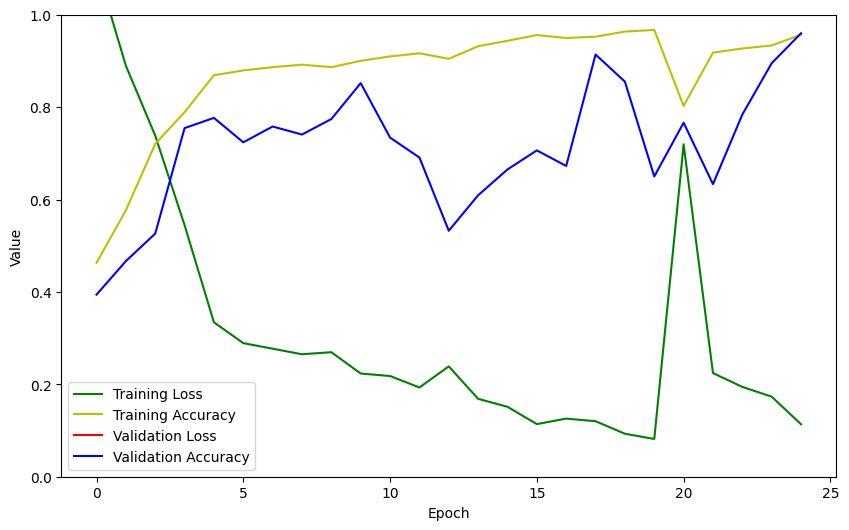

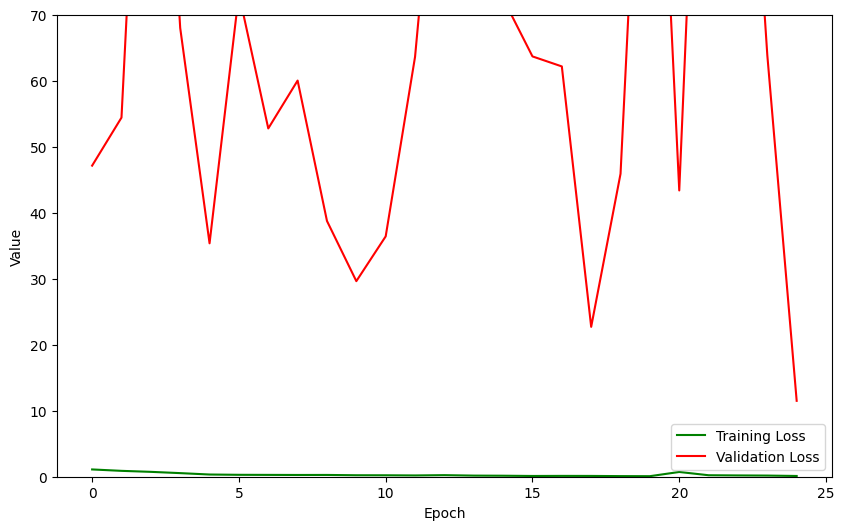

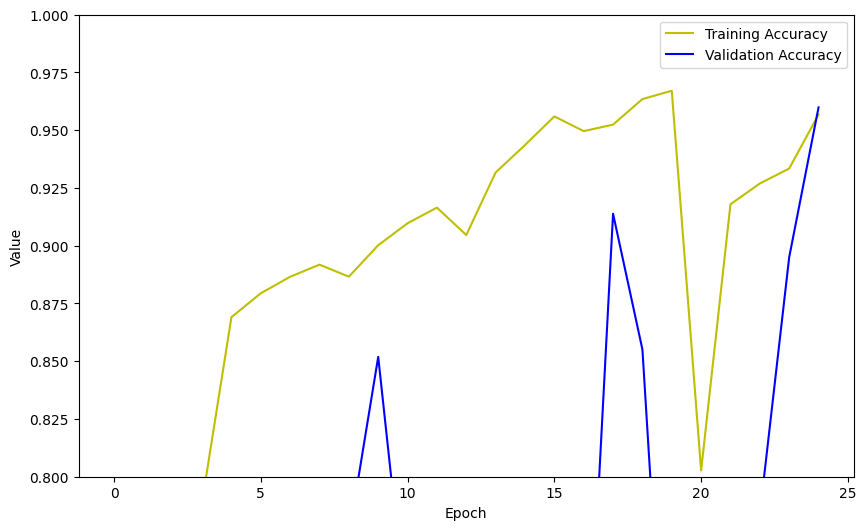


========= TRAINING SET ==========
jaccard index: 0.9069607257843018 

physical jaccard: 0.9383465051651001 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= VALIDATION SET ==========
jaccard index: 0.9228716492652893 

physical jaccard: 0.9339901208877563 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= TEST SET ==========
jaccard index: 0.8913540244102478 

physical jaccard: 0.9283590912818909 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
speci

In [ ]:
run = 2
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 70], [0.8, 1])

#### Run 4

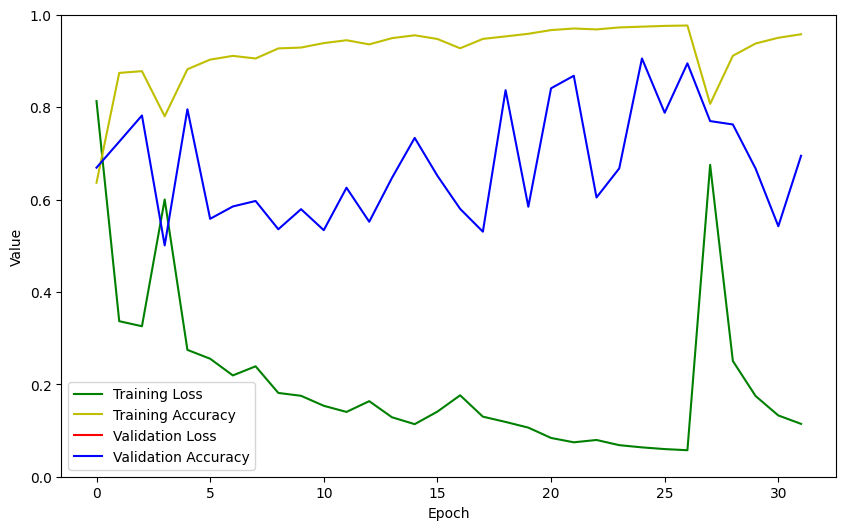

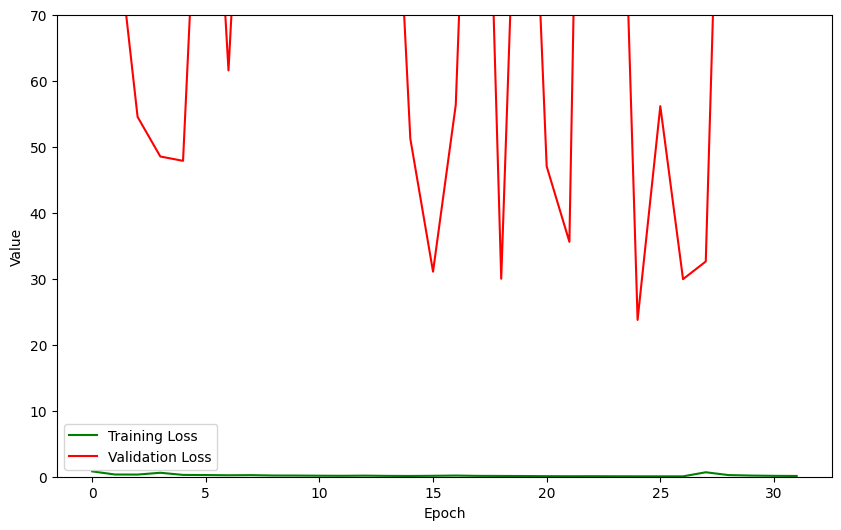

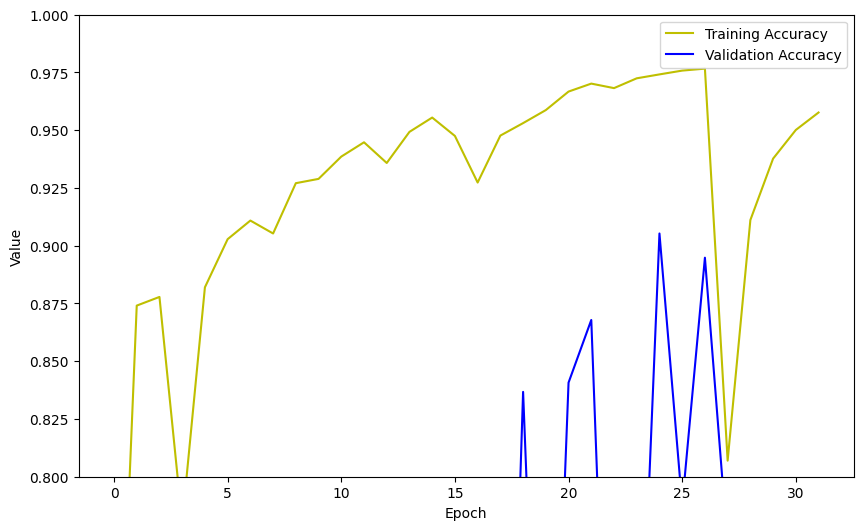


========= TRAINING SET ==========
jaccard index: 0.9141285419464111 

physical jaccard: 0.9383465051651001 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= VALIDATION SET ==========
jaccard index: 0.5321984887123108 

physical jaccard: 0.9339901208877563 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= TEST SET ==========
jaccard index: 0.8983284831047058 

physical jaccard: 0.9283590912818909 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
speci

In [ ]:
run = 3
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 70], [0.8, 1])

#### Run 5

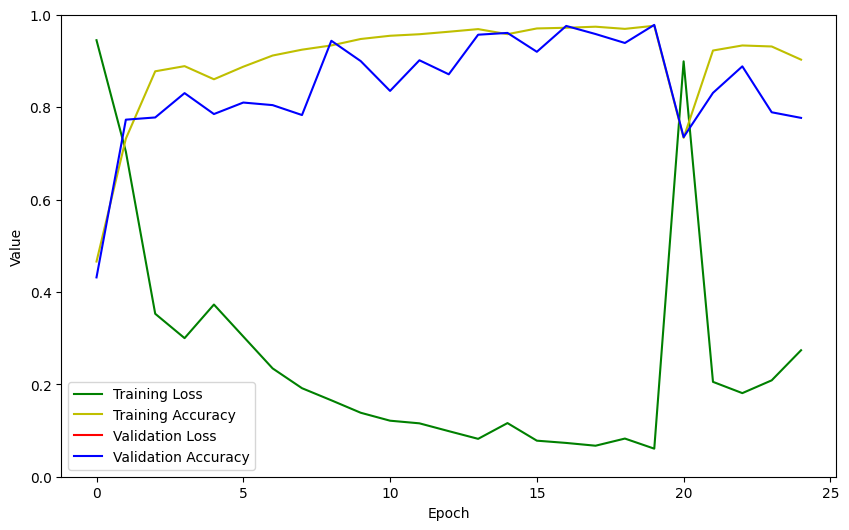

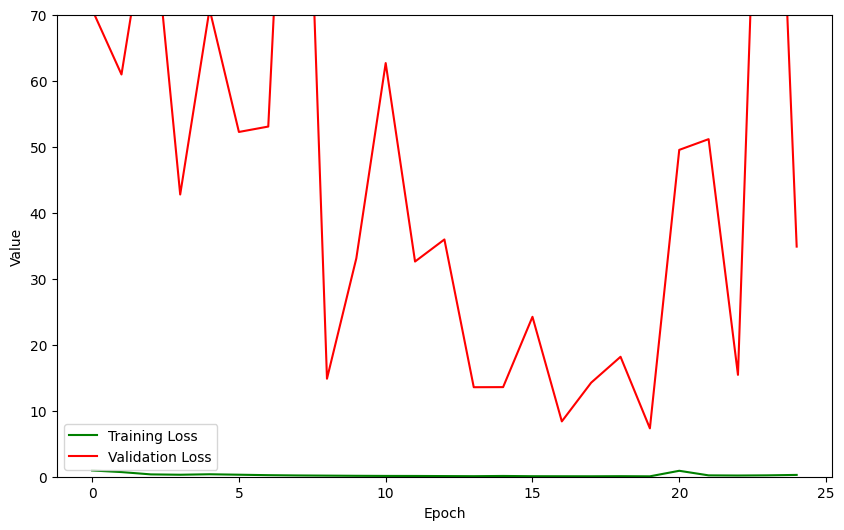

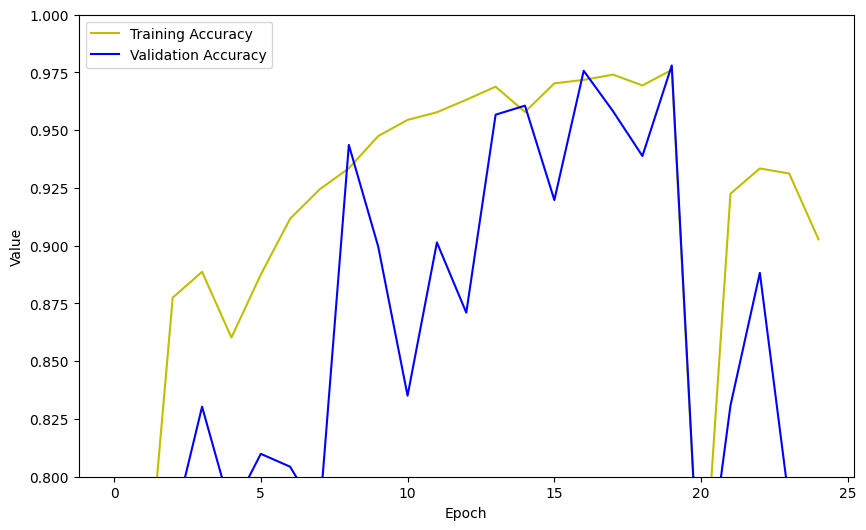


========= TRAINING SET ==========
jaccard index: 0.862406849861145 

physical jaccard: 0.9383465051651001 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= VALIDATION SET ==========
jaccard index: 0.6349184513092041 

physical jaccard: 0.9339901208877563 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= TEST SET ==========
jaccard index: 0.8376128077507019 

physical jaccard: 0.9283590912818909 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specif

In [ ]:
run = 4
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 70], [0.8, 1])

#### Run 6

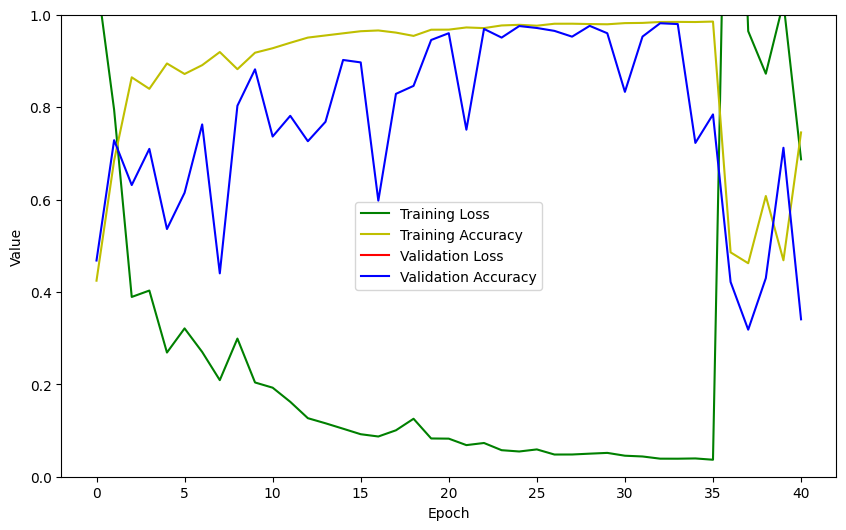

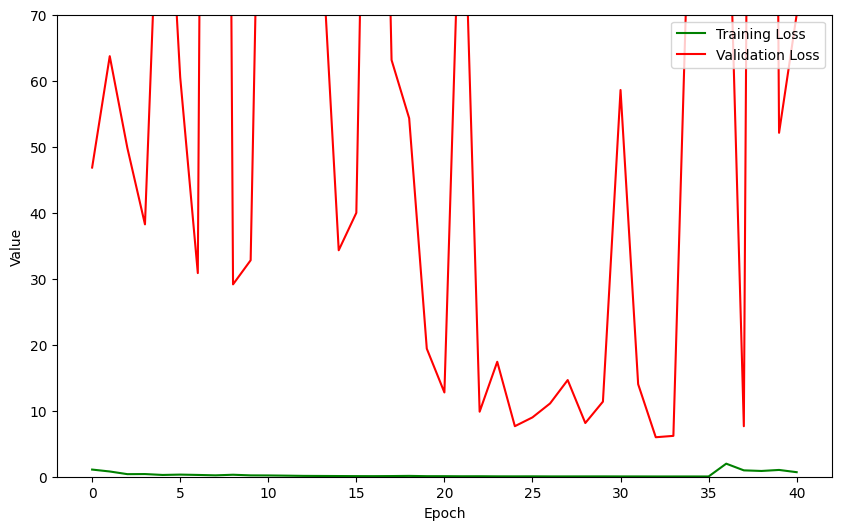

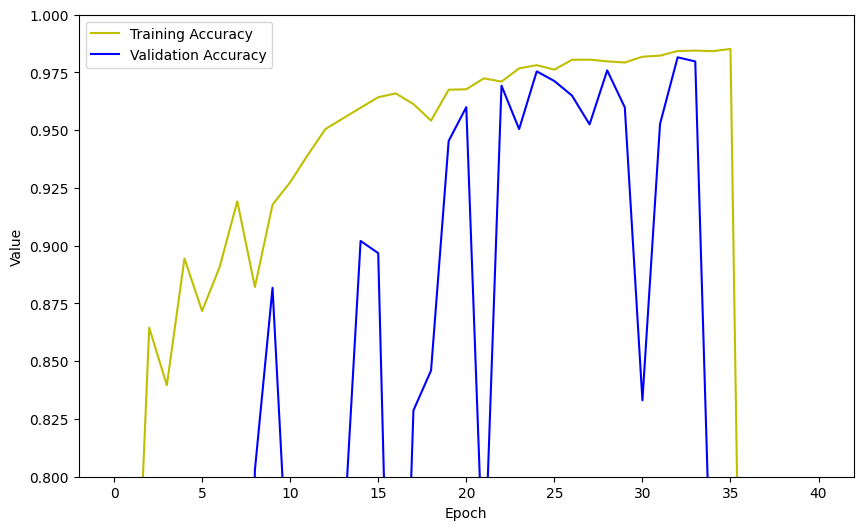


========= TRAINING SET ==========
jaccard index: 0.4428538382053375 

physical jaccard: 0.9383465051651001 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 1.0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= VALIDATION SET ==========
jaccard index: 0.21585704386234283 

physical jaccard: 0.9339901208877563 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= TEST SET ==========
jaccard index: 0.403385728597641 

physical jaccard: 0.9283590912818909 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
spe

In [ ]:
run = 5
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 70], [0.8, 1])

#### Run 7

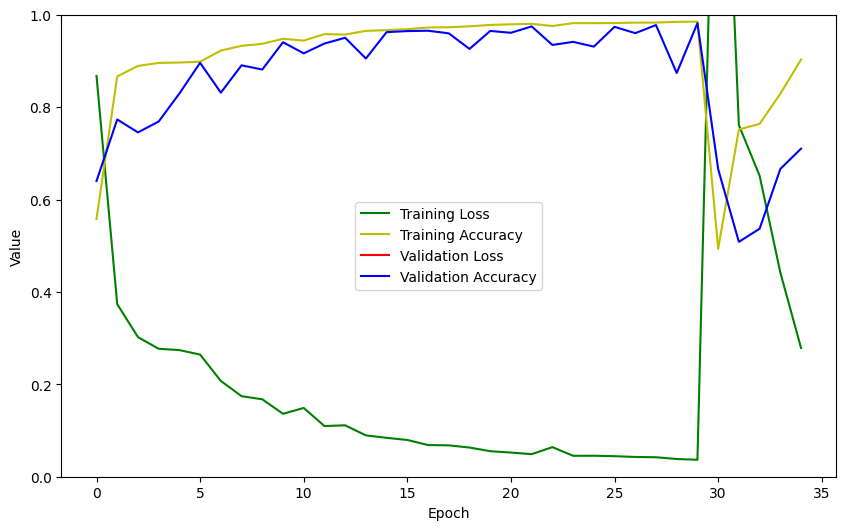

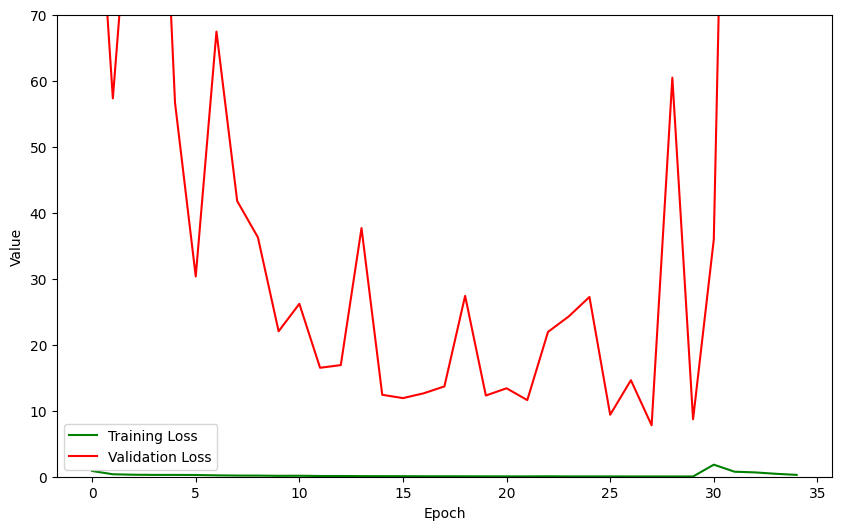

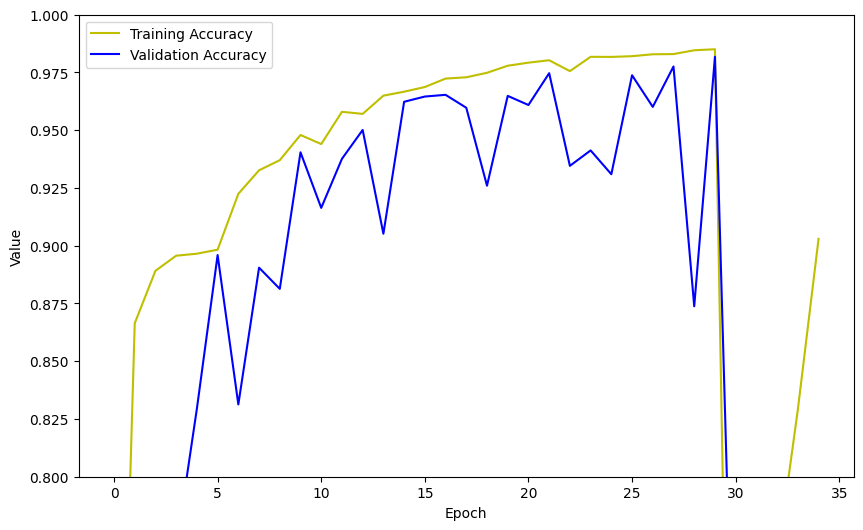


========= TRAINING SET ==========
jaccard index: 0.7743792533874512 

physical jaccard: 0.9383465051651001 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= VALIDATION SET ==========
jaccard index: 0.5493144989013672 

physical jaccard: 0.9339901208877563 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= TEST SET ==========
jaccard index: 0.7251129150390625 

physical jaccard: 0.9283590912818909 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
speci

In [ ]:
run = 6
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 70], [0.8, 1])

#### Run 8

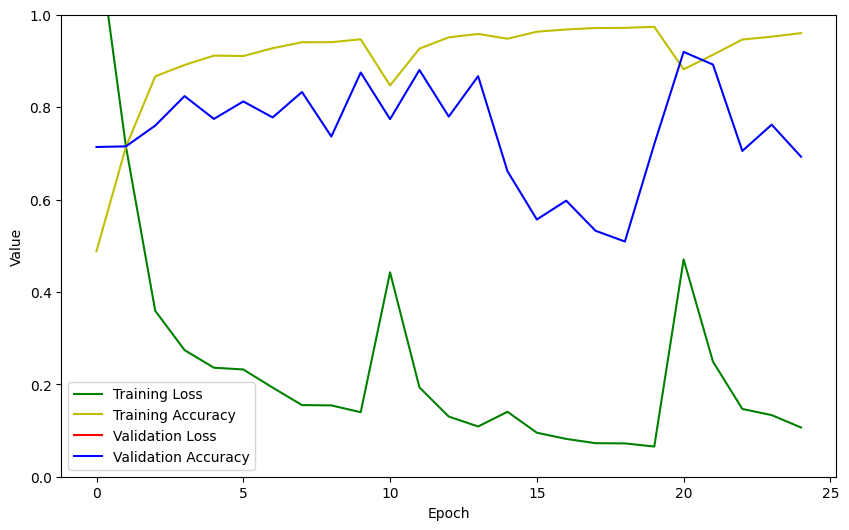

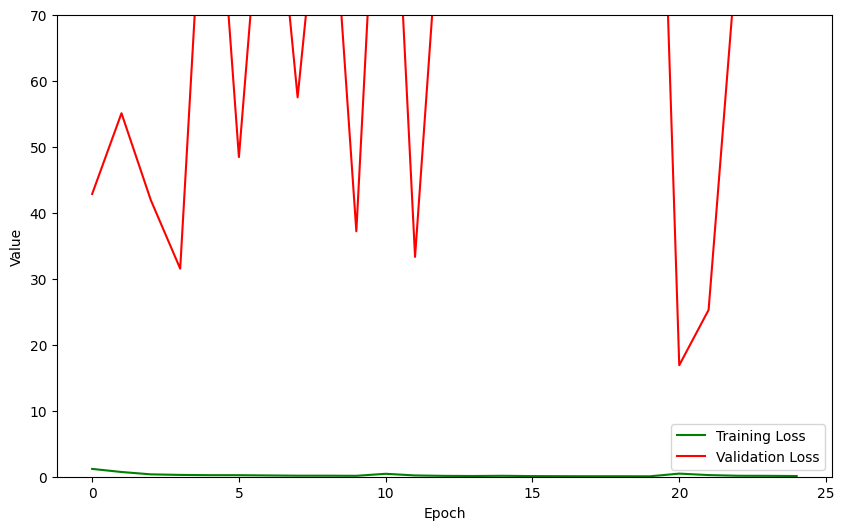

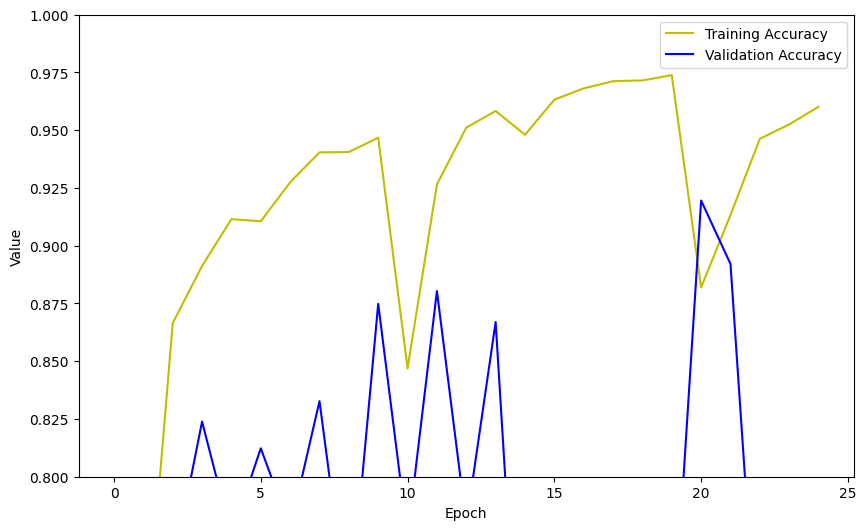


========= TRAINING SET ==========
jaccard index: 0.91584712266922 

physical jaccard: 0.9383465051651001 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= VALIDATION SET ==========
jaccard index: 0.5297876000404358 

physical jaccard: 0.9339901208877563 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= TEST SET ==========
jaccard index: 0.9025120139122009 

physical jaccard: 0.9283590912818909 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specifi

In [ ]:
run = 7
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 70], [0.8, 1])

#### Run 9

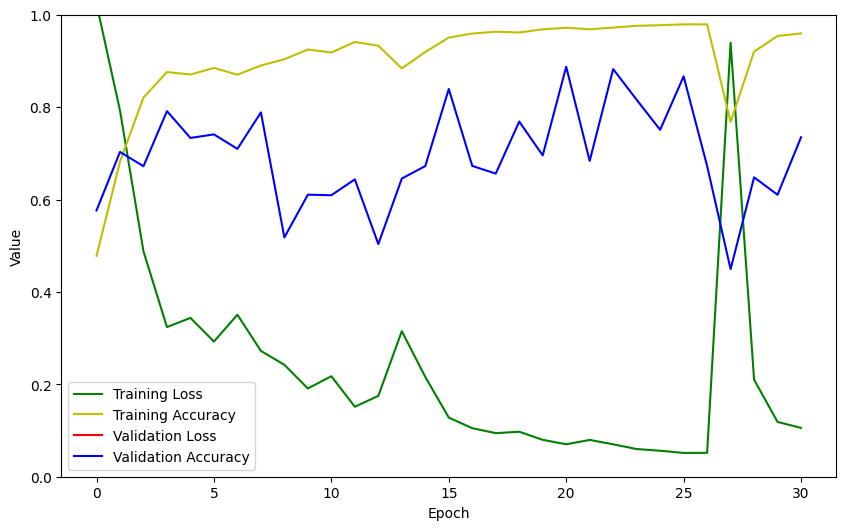

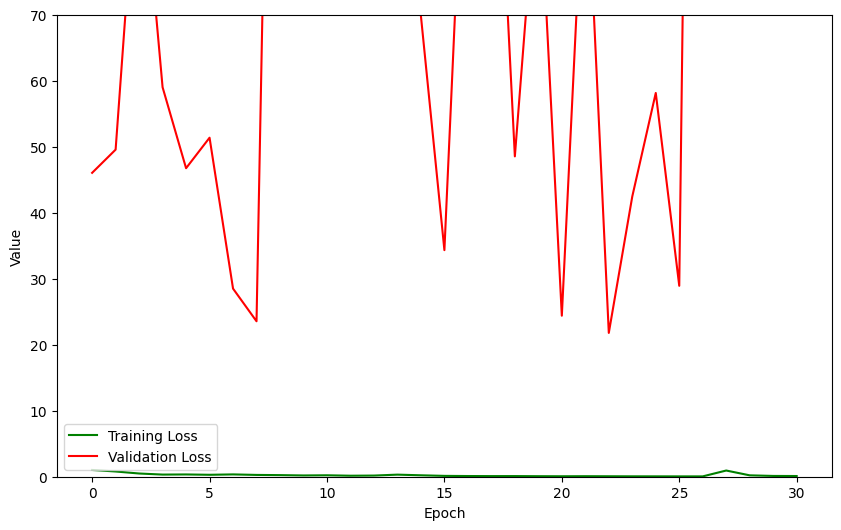

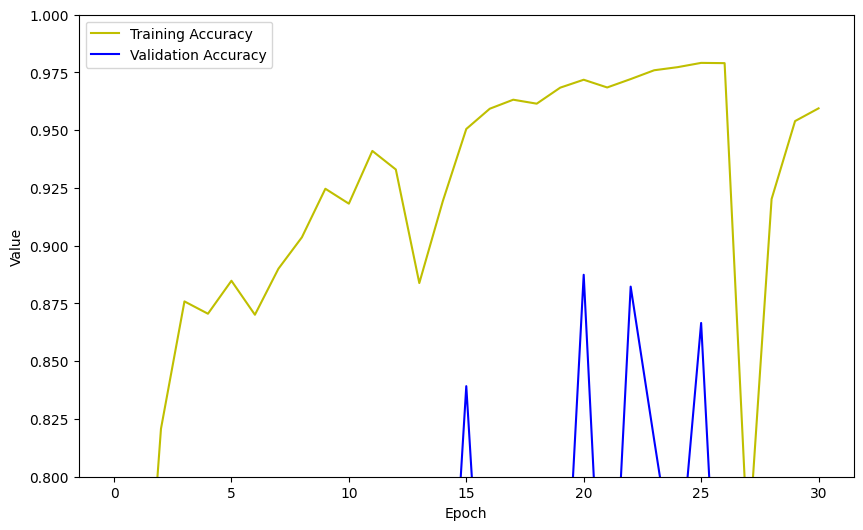


========= TRAINING SET ==========
jaccard index: 0.9015107154846191 

physical jaccard: 0.9383465051651001 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= VALIDATION SET ==========
jaccard index: 0.5807595252990723 

physical jaccard: 0.9339901208877563 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= TEST SET ==========
jaccard index: 0.8924751281738281 

physical jaccard: 0.9283590912818909 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
speci

In [ ]:
run = 8
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 70], [0.8, 1])

#### Run 10

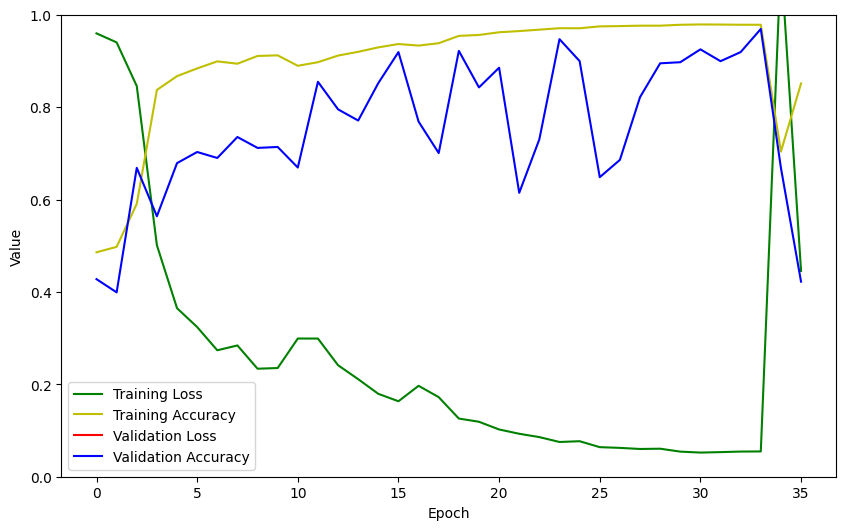

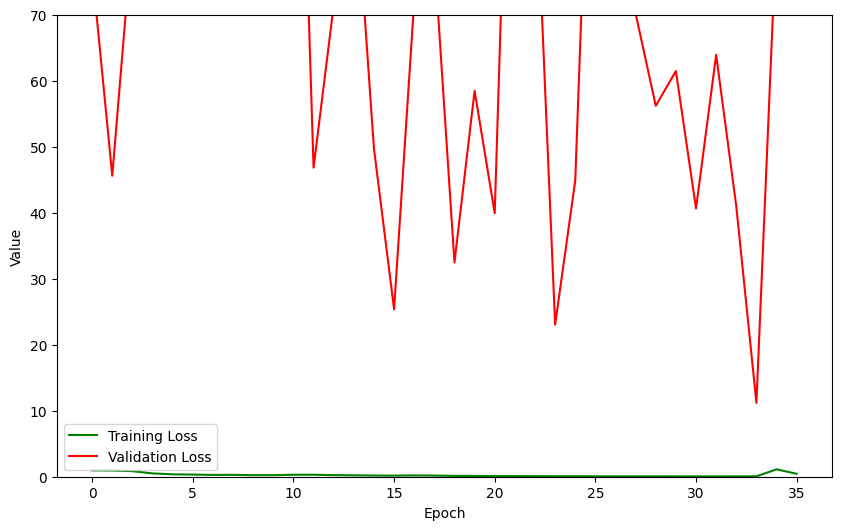

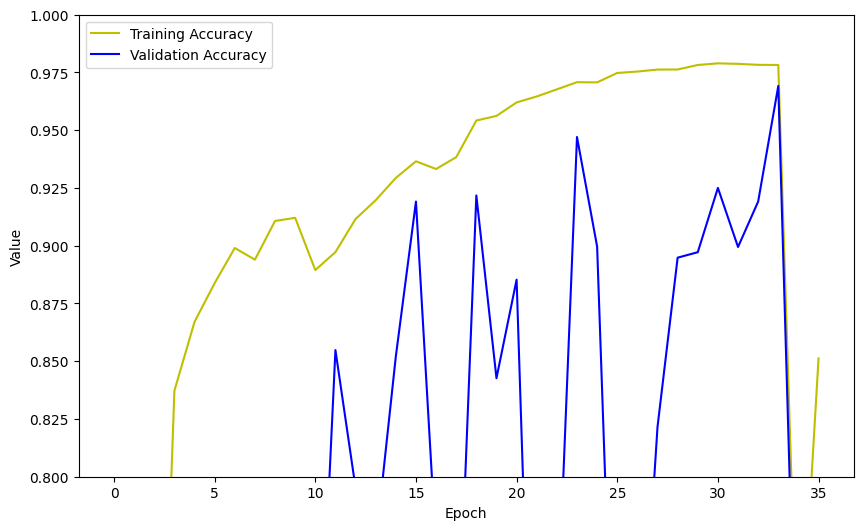


========= TRAINING SET ==========
jaccard index: 0.29047921299934387 

physical jaccard: 0.9383465051651001 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= VALIDATION SET ==========
jaccard index: 0.2675853967666626 

physical jaccard: 0.9339901208877563 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
specificy_invalid_valid: 0
specificy_invalid_invalid: 0 

f1_land: 0
f1_invalid: 0
f1_valid: 0




========= TEST SET ==========
jaccard index: 0.2666495144367218 

physical jaccard: 0.9283590912818909 

precision_land: 0
precision_valid: 0
precision_invalid: 0 

recall_invalid_land: 0
recall_invalid_land: 0
recall_invalid_land: 0 

specificy_invalid_land: 0
spec

In [ ]:
run = 9
print_history_metrics_for_run(histories[run], training_metrics[run], validation_metrics[run], test_metrics[run], [0,1], [0, 70], [0.8, 1])

### 7. Summary

In [ ]:
print('============ TEST DATA ===================')
get_mean_jaccard(training_metrics)
print()

print('============ VALIDATION DATA ===================')
get_mean_jaccard(validation_metrics)
print()

print('============ TRAINING DATA ===================')
get_mean_jaccard(test_metrics)
print()

============ TEST DATA ===================
tf.Tensor(0.79084444, shape=(), dtype=float32)
tf.Tensor(0.53105325, shape=(), dtype=float32)
tf.Tensor(0.9069607, shape=(), dtype=float32)
tf.Tensor(0.91412854, shape=(), dtype=float32)
tf.Tensor(0.86240685, shape=(), dtype=float32)
tf.Tensor(0.44285384, shape=(), dtype=float32)
tf.Tensor(0.77437925, shape=(), dtype=float32)
tf.Tensor(0.9158471, shape=(), dtype=float32)
tf.Tensor(0.9015107, shape=(), dtype=float32)
tf.Tensor(0.2904792, shape=(), dtype=float32)

Mean jaccard index: 0.7330464124679565

Worst index: 0.29047921299934387
Best index: 0.91584712266922
Variance: 0.6253678798675537

============ VALIDATION DATA ===================
tf.Tensor(0.88274467, shape=(), dtype=float32)
tf.Tensor(0.36558786, shape=(), dtype=float32)
tf.Tensor(0.92287165, shape=(), dtype=float32)
tf.Tensor(0.5321985, shape=(), dtype=float32)
tf.Tensor(0.63491845, shape=(), dtype=float32)
tf.Tensor(0.21585704, shape=(), dtype=float32)
tf.Tensor(0.5493145, shape=(

Training time: 48 min

Computing units needed: 15,29 (13,08 / h => should have been only 10,46 ??)

In [ ]:
# todo show couple of predictions

### open questions


training loss is always a couple of epochs before last one ~ 100 times better

| Best Epoch | Total amount of epochs |
|------------|-----------------|
| 19  | 25  |
| 26  | 40  |
| 18  | 25  |
| 29  | 35  |
| 18  | 25  |
| 25  | 31  |
| 28  | 36  |




ZeroDivisionError: division by zero => Training 5 and not 6??

`Error 0 values: 0`

42,13 remaining computing units before starting